### Note:

To run in Colab, you will need to add the datasets/ folder to your Google Drive as /data/ (in your Google Drive root directory).

In [1]:
%matplotlib inline
!pip install transformers
import math
import nltk
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import unittest

from collections import Counter
from datetime import datetime
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

## Utils

In [2]:
def set_seed(seed, device='cuda'):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

class TwoWayDict(dict):
    # From https://stackoverflow.com/questions/1456373/two-way-reverse-map
    def __setitem__(self, key, value):
        # Remove any previous connections with these values
        if key in self:
            del self[key]
        if value in self:
            del self[value]
        dict.__setitem__(self, key, value)
        dict.__setitem__(self, value, key)

    def __delitem__(self, key):
        dict.__delitem__(self, self[key])
        dict.__delitem__(self, key)

    def __len__(self):
        """Returns the number of connections"""
        return dict.__len__(self) // 2

def read_tsv(path):
  results = []
  with open(path) as f:
    f.readline()
    for line in f:
      results.append(line.split('\t')) 
  return results

### Reuters8 Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Use a separate `Vocabulary` class that can aggregate vocabularies for whole datassets acrosss train/val/test split. This allows for more accurate word-counting & better integration with NVDM.

In [5]:
class Vocabulary():
  '''Creates a case-insensitive, dictionary-like vocabulary from a raw, 
  tab-separated dataset.

  `Vocabulary` is essentially a wrapper on the builtin `Counter` class. This class
  implements __getitem__, which returns the frequency of a given word.

  Args:
    filenames (:obj:`list` of :obj:`str`): Names of TSV files making up the full
      dataset whose vocabulary you want to index. Typically 'train', 'val', and 
      'test' files.
    col_num (:obj:`int`, optional): Set to `1` by default. The column in the TSV
      containing raw text. This starts from 0 (e.g. 1 is the 2nd column).
    include_stopwords(:obj:`bool`, optional): Set to `False` by default. If `True`,
      the vocabulary will include words listed in NLTK's stopwords dataset.
    f_min(:obj:`int`, optional): Set to `10` by default. All words with 
      frequency < f_min are removed from the vocabulary.

  '''

  def __init__(self, filepaths, col_num=1, include_stopwords=False, f_min=10):
    texts = []
    for filepath in filepaths:
      texts += [x[col_num] for x in read_tsv(filepath)]

    words = [word.lower() for text in texts for word in text.split(' ')]

    if not include_stopwords:
      # remove stopwords, newline
      stops = stopwords.words('english')
      words = [x for x in words if x not in stops]

    c = Counter(words)
    self._vocab = Counter({k: c for k, c in c.items() if c >= f_min})

  @property 
  def words(self):
    return list(self._vocab.keys())

  def __getitem__(self, word):
        return self._vocab[word]

  def __len__(self):
    return len(self.words)

f_names = ['training.tsv', 'validation.tsv', 'test.tsv']
f_paths = ['/content/drive/My Drive/data/Reuters8/' + x for x in f_names]
r8_vocab = Vocabulary(f_paths)
print(len(r8_vocab))

4832


In [6]:
class Reuters8Dataset(Dataset):
    '''Initializes a PyTorch Dataset with the appropriate Reuters8 data.
    
    Args:
        filename (str): The name of the file containing Ruters8 label/sentence pairs as TSV. This should be 
            one of 'training', 'test', 'validation'. The files must be located at <cwd>/datasets/Reuters8/
        vocab (:obj:`Vocabulary`): A vocabulary object that determines which words are retained by
            the dataset when cleaning examples.
        label_filepath (:obj:`str`, optional): The label file containing the label ordering, separated by 
            newlines. By default, this looks to <cwd>/datasets/Reuters8/labels.txt. 
        one_hot (:obj:`bool`, optional): Set to True by default. Determines if labels are one-hot encoded 
            vectors (True) or topic strings (False)
    '''
    REUTERS_URI = '/content/drive/My Drive/data/Reuters8/'
    
    def _clean_examples(self, examples):
        # Switches order of label, sent in dataset. Removes words not in vocab.
        cleaned = []
        words = self.vocab.words
        for ex in examples:
            label, sent = ex
            new_sent = ' '.join([x.lower() for x in sent.split(' ') if x.lower() in words])
            cleaned.append([new_sent, label])
            
        return cleaned
    
    def __init__(self, filename, vocab, label_filepath=None, one_hot=True):
        self.vocab = vocab
        if label_filepath is None:
            label_filepath = os.path.join(self.REUTERS_URI, 'labels.txt')
            
        with open(label_filepath) as f:
            self.labels = [x.strip() for x in f.read().strip().split('\n')]
    
        self.label_mapping = TwoWayDict()
        for i, label in enumerate(self.labels):
            self.label_mapping[label] = i
            
        path = os.path.join(self.REUTERS_URI, filename)
        self.examples = self._clean_examples(read_tsv(path))
        
        if one_hot:
            for i, ex in enumerate(self.examples):
                _, label = ex
                lbl_one_hot = torch.full((len(self.labels),), 0)
                lbl_one_hot[self.label_mapping[label]] = 1
                self.examples[i][1] =  lbl_one_hot
                
    @property
    def num_labels(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.examples[index]
        
    def __len__(self):
        return len(self.examples)
                
        
r8_train = Reuters8Dataset('training.tsv', r8_vocab)
r8_val = Reuters8Dataset('validation.tsv', r8_vocab)
r8_test = Reuters8Dataset('test.tsv', r8_vocab)

In [7]:
if True: # Set to false to not show example
    ex = 107
    print('Sample sent/label pair — Ex #{}:'.format(ex))
    print('\t- sent:',r8_train[ex][0].strip()) 
    print('\t- one-hot:',r8_train[ex][1]) 
    # convert one-hot label to int & string
    lbl_idx = torch.where(r8_train[ex][1] > 0)[0].item()
    print('\t- int:',lbl_idx) 
    print('\t- str:',r8_train.label_mapping[lbl_idx])

Sample sent/label pair — Ex #107:
	- sent: interco inc th qtr feb net shr cts vs cts net vs sales mln vs mln year shr dlrs vs dlrs net vs sales billion vs billion note results reflect two one stock split july reuter
	- one-hot: tensor([0, 0, 1, 0, 0, 0, 0, 0])
	- int: 2
	- str: earn


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# We need to provide a custom collate function to DataLoader because we're handling sentences of varying lengths. 
def collate_fn_bert(batch):
  # https://huggingface.co/transformers/preprocessing.html
  sents, labels = zip(*batch)
  labels = torch.stack([x.long() for x in labels])
  encoded = tokenizer(sents, padding=True, max_length=512, truncation=True, return_tensors='pt')
  # print([len(x) for x in encoded['input_ids']])
  # print(any([len(x) > 512 for x in encoded['input_ids']]))
  return encoded['input_ids'], encoded['attention_mask'], labels

set_seed(42)
dataloader_val = DataLoader(r8_val, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn_bert)

if True: # Set to false to not show example
    for i, (input_ids, attention_mask, labels) in enumerate(dataloader_val):
      if i == 2:
        print(input_ids[3])
        print(tokenizer.convert_ids_to_tokens(input_ids[3]))
        print(tokenizer.decode(input_ids[3]))
        print(attention_mask[3])
        print(labels[3])

tensor([  101,  7156,  3001,  4297,  2095, 13292,  3279,  6728,  2121, 14021,
         2099,  3279,  2274, 14931,  2015,  5443,  3279, 21469,  2869,  6728,
         2121,  5658,  3279,  5443,  3279,  4341, 19875,  2078,  5443, 19875,
         2078,  3602,  5658, 23329,  2015,  6409,  8944,  3136, 21469,  2869,
         5443, 21469,  2869,  2128, 19901,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [9]:
def get_init_transformer(transformer):
  """
  Initialization scheme used for transformers:
  https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
  """
  def init_transformer(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        module.weight.data.normal_(mean=0.0, std=transformer.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

  return init_transformer


class BertClassifier(nn.Module):

  def __init__(self, num_labels, drop=0.1):
    super().__init__()
    self.encoder = BertModel.from_pretrained('bert-base-uncased')
    self.score = nn.Sequential(nn.Dropout(drop), 
                               nn.Linear(self.encoder.config.hidden_size, num_labels))
    self.score.apply(get_init_transformer(self.encoder))  # Important to initialize any additional weights the same way as pretrained encoder. 
    self.loss = nn.CrossEntropyLoss(reduction='mean')

  def forward(self, input_ids, attention_mask, labels):
    hiddens_last = self.encoder(input_ids, attention_mask=attention_mask)[0]  # (batch_size, length, dim), these are last layer embeddings
    embs = hiddens_last[:,0,:]  # [CLS] token embeddings
    logits = self.score(embs)
    # Runs cross-entropy softmax loss on labels
    loss_total = self.loss(logits, torch.max(labels, 1)[1])
    return logits, loss_total

In [10]:
def configure_optimization(model, num_train_steps, num_warmup_steps, lr, weight_decay=0.01):  
  # Copied from: https://huggingface.co/transformers/training.html
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
                                   'weight_decay': weight_decay},
                                  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                                   'weight_decay': 0.}]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr)  
  scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=num_train_steps, num_warmup_steps=num_warmup_steps) 
  return optimizer, scheduler

In [11]:
def get_acc_val(model, device):
  num_correct_val = 0
  model.eval()  
  with torch.no_grad(): 
    for input_ids, attention_mask, labels in dataloader_val:
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)
      logits, _ = model(input_ids, attention_mask, labels) 
      preds = torch.max(logits, 1)[1] # get label from max score per example
      num_correct_val += (preds == torch.max(labels, 1)[1]).sum()
  acc_val = num_correct_val / len(dataloader_val.dataset) * 100.
  return acc_val

In [12]:
def train(model, batch_size=32, num_warmup_steps=10, lr=0.00005, num_epochs=3, clip=1., verbose=True, device='cuda'):
  model = model.to(device)  # Move the model to device.  
  dataloader_train = DataLoader(r8_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn_bert) 
  num_train_steps = len(r8_train) // batch_size * num_epochs
  optimizer, scheduler = configure_optimization(model, num_train_steps, num_warmup_steps, lr)

  loss_avg = float('inf')
  acc_train = 0.
  best_acc_val = 0.
  for epoch in range(num_epochs):
    model.train()  # This turns on the training mode (e.g., enable dropout).
    loss_total = 0.
    num_correct_train = 0
    for batch_ind, (input_ids, attention_mask, labels) in enumerate(dataloader_train):
      if (batch_ind + 1) % 200 == 0: 
        print(batch_ind + 1, '/', len(dataloader_train), 'batches done')
      input_ids = input_ids.to(device).long()
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)      
      logits, loss_batch_total = model(input_ids, attention_mask, labels) 
      preds = torch.max(logits, 1)[1]  # get label from max score per example
      num_correct_train += (preds == torch.max(labels, 1)[1]).sum()
      loss_total += loss_batch_total.item()            
      
      loss_batch_avg = loss_batch_total / input_ids.size(0)  
      loss_batch_avg.backward()  

      if clip > 0.:  # Optional gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()  # optimizer updates model weights based on stored gradients
      scheduler.step()  # Update lr. 
      optimizer.zero_grad()  # Reset gradient slots to zero

    # Useful training information
    loss_avg = loss_total / len(dataloader_train.dataset)
    acc_train = num_correct_train / len(dataloader_train.dataset) * 100.

    # Check validation performance at the end of every epoch. 
    acc_val = get_acc_val(model, device)

    if verbose:
      print('Epoch {:3d} | avg loss {:8.4f} | train acc {:2.2f} | val acc {:2.2f}'.format(epoch + 1, loss_avg, acc_train, acc_val))

    if acc_val > best_acc_val: 
      best_acc_val = acc_val
  
  if verbose: 
    print('Final avg loss {:8.4f} | final train acc {:2.2f} | best val acc {:2.2f}'.format(loss_avg, acc_train, best_acc_val))

  return best_acc_val

## Below Runs BERT on Reuters8

In [13]:
!pip install ipython-autotime  # Useful library for tracking runtime on Python Notebooks
 
%load_ext autotime

time: 139 µs (started: 2021-04-19 21:26:07 +00:00)


In [ ]:
if True: # Set True to run. 
  torch.cuda.empty_cache()
  set_seed(42)
  model = BertClassifier(r8_train.num_labels)
  best_acc_val = train(model, batch_size=4)

200 / 1247 batches done
400 / 1247 batches done
600 / 1247 batches done
800 / 1247 batches done
1000 / 1247 batches done
1200 / 1247 batches done
Epoch   1 | avg loss   0.0596 | train acc 93.36 | val acc 96.40
200 / 1247 batches done
400 / 1247 batches done
600 / 1247 batches done
800 / 1247 batches done
1000 / 1247 batches done
1200 / 1247 batches done
Epoch   2 | avg loss   0.0180 | train acc 98.48 | val acc 96.60
200 / 1247 batches done
400 / 1247 batches done
600 / 1247 batches done
800 / 1247 batches done
1000 / 1247 batches done
1200 / 1247 batches done
Epoch   3 | avg loss   0.0070 | train acc 99.30 | val acc 97.20
Final avg loss   0.0070 | final train acc 99.30 | best val acc 97.20
time: 9min 44s (started: 2021-04-18 20:13:09 +00:00)


## NVDM

Here we implement NVDM as a standalone topic modeler. NVDM is a neural VAE. The goal is to concatenate the output of NVDM's encoder, the posterior distribution $q(\mathbf{h} | \mathbf{B})$ with BERT's output (the embedding of the `[CLS]` token), and then fine-tune a joint loss between the two. $\mathbf{B}$ is the BOW representation of a document $\mathcal{D}$.

In [14]:
class BOWDataset(Dataset):
    '''This class servess as a wrapper for an existing dataset that serves
    a BOW repesentation as well as the original. The BOW conversion is done upon
    instantiation for efficiency when training.
    
    Args:
      dataset (:obj:`torch.utils.data.Dataset`): The dataset to serve as BOW
      vocab (:obj:`Vocabulary`): The vocabulay associated with the dataset.
      binary (:obj:`bool`, optional): Whether the BOW should maintain a binary
        representation. If `False`, it will contain word frequencies (integers).
    '''

    def __init__(self, dataset, vocab, binary=False):
      self.vocab = vocab
      self.examples = []
      for sent, label in dataset:
        bow = torch.zeros((len(vocab),), dtype=torch.long)
        for word in sent.split(' '):
          word_index = vocab.words.index(word)
          if binary:
            bow[word_index] = 1
          else:
            bow[word_index] += 1

        self.examples.append([sent, bow, label])

    def __getitem__(self, index):
        return self.examples[index]

    def __len__(self):
        return len(self.examples)

r8_train_bow = BOWDataset(r8_train, r8_train.vocab)
r8_val_bow = BOWDataset(r8_val, r8_val.vocab)
r8_test_bow = BOWDataset(r8_test, r8_test.vocab)

time: 36.2 s (started: 2021-04-19 21:26:07 +00:00)


In [15]:
print(r8_train[10])
print(r8_train_bow[10])
print(torch.where(r8_train_bow[10][1] > 0)[0])
# Frequency of word 'bell' in example
print(r8_train_bow[10][1][396].item())

['bell resources boosts stake bhp bell resources ltd said executed underwriting agreement equiticorp ltd acquire mln ordinary shares broken hill pty co ltd mln dlrs bell said statement holds pct bhp billion shares reuter\n', tensor([1, 0, 0, 0, 0, 0, 0, 0])]
['bell resources boosts stake bhp bell resources ltd said executed underwriting agreement equiticorp ltd acquire mln ordinary shares broken hill pty co ltd mln dlrs bell said statement holds pct bhp billion shares reuter\n', tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([1, 0, 0, 0, 0, 0, 0, 0])]
tensor([  4,  15,  19,  23,  30,  51, 119, 273, 377, 388, 396, 397, 398, 399,
        400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410])
3
time: 5.92 ms (started: 2021-04-19 21:26:44 +00:00)


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# We need to provide a custom collate function to DataLoader because we're handling sentences of varying lengths. 
def collate_fn_topicbert(batch):
  # https://huggingface.co/transformers/preprocessing.html
  sents, bows, labels = zip(*batch)
  labels = torch.stack([x.long() for x in labels])
  encoded = tokenizer(sents, padding=True, max_length=512, truncation=True, return_tensors='pt')
  return encoded['input_ids'], encoded['attention_mask'], torch.stack(bows).float(), labels

dataloader_val_tb = DataLoader(r8_val_bow, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn_topicbert)

time: 1.21 s (started: 2021-04-19 21:26:44 +00:00)


In [17]:
for i, (input_ids, attention_mask, bows, labels) in enumerate(dataloader_val_tb):
  if i == 3: # Batch #
    print('BERT Token(izer):\n------------')
    print(input_ids[3])
    print(tokenizer.convert_ids_to_tokens(input_ids[3]))
    print(tokenizer.decode(input_ids[3]))
    print(attention_mask[3])
    print(bows[3])
    print('\nBOW:\n------------')
    idxs=torch.where(bows[3] > 0)[0]
    print(idxs)
    print([r8_val_bow.vocab.words[x] for x in idxs])
    print('\nLabel:\n------------')
    print(labels[3])
    print(r8_val.label_mapping[torch.where(labels[3] > 0)[0].item()])
    break

BERT Token(izer):
------------
tensor([  101,  6262, 15827,  3477,  5833,  6262, 15827,  2522,  2056,  2604,
         5501,  5444, 28324,  7909, 11443, 18376, 15337,  6262, 15827,  2056,
         7079, 12174, 11443,  4859,  2028, 14931,  3745,  2691,  4518,  2194,
         2056, 24273,  3828, 19875,  2078, 21469,  2869,  2095, 11443,  4859,
         8636,  2128, 19901,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     

In [18]:
class NVDM(nn.Module):
  @staticmethod
  def _param_initializer(module):
    if isinstance(module, nn.Linear):
      nn.init.xavier_normal_(module.weight)

    if isinstance(module, nn.Linear) and module.bias is not None:
      module.bias.data.zero_()

  def __init__(self, vocab_size, num_topics=50, hidden_size=256, hidden_layers=1, nonlinearity=nn.Tanh):
    super().__init__()
    self.num_topics = num_topics
    self.vocab_size = vocab_size

    # First MLP layer compresses from vocab_size to hidden_size
    mlp_layers = [nn.Linear(vocab_size, hidden_size), nonlinearity()]
    # Remaining layers operate in dimension hidden_size
    for _ in range(hidden_layers - 1):
      mlp_layers.append(nn.Linear(hidden_size, hidden_size))
      mlp_layers.append(nonlinearity())

    self.mlp = nn.Sequential(*mlp_layers)
    self.mlp.apply(NVDM._param_initializer)

    # Create linear projections for Gaussian params (mean & sigma)
    self.mean = nn.Linear(hidden_size, num_topics)
    self.mean.apply(NVDM._param_initializer)

    # Custom initialization for log_sigma
    self.log_sigma = nn.Linear(hidden_size, num_topics)
    self.log_sigma.bias.data.zero_()
    self.log_sigma.weight.data.fill_(0.)

    self.dec_projection = nn.Linear(num_topics, vocab_size)
    self.log_softmax = nn.LogSoftmax(-1)

  def forward(self, input_bows):
    # Run BOW through MLP
    pi = self.mlp(input_bows)

    # Use this to get mean, log_sig for Gaussian
    mean = self.mean(pi)
    log_sigma = self.log_sigma(pi)

    # Calculate KLD
    kld = -0.5 * torch.sum(1 - torch.square(mean) + (2 * log_sigma - torch.exp(2 * log_sigma)), 1)
    # kld = mask * kld  # mask paddings

    # Use Gaussian reparam. trick to sample from distribution defined by mu, sig
    # This provides a sample h_tm from posterior q(h_tm | V) (tm meaning topic model)
    epsilons = torch.normal(0, 1, size=(input_bows.size()[0], self.num_topics)).to(input_bows.device)
    sample = (torch.exp(log_sigma) * epsilons) + mean

    # Softmax to get p(v_i | h_tm), AKA probabilities of words given hidden state
    logits = self.log_softmax(self.dec_projection(sample)) 

    # Lowerbound on NVDM true loss, used for optimization
    rec_loss = -1 * torch.sum(logits * input_bows, 1)
    loss_nvdm_lb = torch.mean(rec_loss + kld)

    return sample, logits, loss_nvdm_lb


time: 45.3 ms (started: 2021-04-19 21:26:45 +00:00)


In [19]:
def train_nvdm(model, batch_size=32, lr=0.00005, epochs=1000, verbose=True, device='cuda'):
  model = model.to(device)  # Move the model to device.  
  dataloader_train = DataLoader(r8_train_bow, batch_size=batch_size, shuffle=True, 
                                num_workers=2, collate_fn=collate_fn_topicbert)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  loss_avg = float('inf')
  losses = []
  for epoch in range(epochs):
    model.train()  # This turns on the training mode (e.g., enable dropout).
    loss_total = 0.
    num_correct_train = 0
    for _, _, input_bows, _ in dataloader_train:
      input_bows = input_bows.to(device)
      _, _, loss_batch_total = model(input_bows) 
      loss_total += loss_batch_total.item()            
      
      loss_batch_avg = loss_batch_total / input_bows.size(0)  
      loss_batch_avg.backward()  

      optimizer.step()  # optimizer updates model weights based on stored gradients
      optimizer.zero_grad()  # Reset gradient slots to zero

    # Useful training information
    loss_avg = loss_total / len(dataloader_train.dataset)
    losses.append(loss_avg)

    if verbose and (epoch + 1) % 50 == 0:
      print('Epoch {:3d} | avg loss {:8.4f} '.format(epoch + 1, loss_avg))
  
  if verbose: 
    print('Final avg loss {:8.4f}'.format(loss_avg))
    
  return loss_avg, losses

time: 22.2 ms (started: 2021-04-19 21:26:45 +00:00)


Epoch  50 | avg loss 101.5623 
Epoch 100 | avg loss  96.5617 
Epoch 150 | avg loss  94.0050 
Epoch 200 | avg loss  92.1392 
Epoch 250 | avg loss  91.1717 
Epoch 300 | avg loss  90.5077 
Epoch 350 | avg loss  89.9338 
Epoch 400 | avg loss  89.6736 
Epoch 450 | avg loss  89.3489 
Epoch 500 | avg loss  89.0162 
Epoch 550 | avg loss  88.8845 
Epoch 600 | avg loss  88.6974 
Epoch 650 | avg loss  88.7827 
Epoch 700 | avg loss  88.3320 
Epoch 750 | avg loss  88.2300 
Epoch 800 | avg loss  88.1239 
Epoch 850 | avg loss  88.0998 
Epoch 900 | avg loss  87.9714 
Epoch 950 | avg loss  87.8886 
Epoch 1000 | avg loss  87.8035 
Final avg loss  87.8035


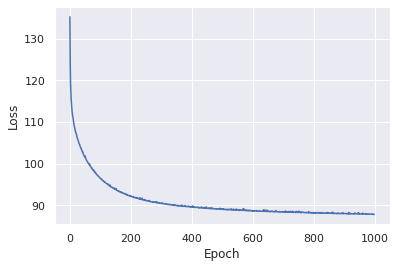

time: 1h 21min 11s (started: 2021-04-19 00:43:43 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if True: # Set True to run. 
  torch.cuda.empty_cache()
  set_seed(42)
  model = NVDM(len(r8_train.vocab))
  avg_loss, losses = train_nvdm(model, batch_size=4)

  sns.set(style='darkgrid')
  plt.plot(np.array(losses))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

## TopicBERT

Here we merge BERT & NVDM together to yield TopicBERT

In [20]:
class TopicBert(nn.Module):
  def __init__(self, vocab_size, num_labels, alpha=0.9):
    super().__init__()
    self.alpha = alpha
    self.encoder = BertModel.from_pretrained('bert-base-uncased')
    self.nvdm = NVDM(vocab_size)
    self.projection = nn.Sequential(
      nn.Linear(self.encoder.config.hidden_size + self.nvdm.num_topics, 
                self.nvdm.num_topics, bias=False), 
      # nn.GELU() # This is NOT used in paper, but it is used in TF source...
      nn.Linear(self.nvdm.num_topics, num_labels)
    )
    self.projection.apply(get_init_transformer(self.encoder)) 

    self.bert_loss = nn.CrossEntropyLoss(reduction='mean')

  def forward(self, input_ids, attention_mask, bows, labels):
    hiddens_last = self.encoder(input_ids, attention_mask=attention_mask)[0]  # (batch_size, length, dim), these are last layer embeddings
    embs = hiddens_last[:,0,:]  # [CLS] token embeddings
    
    h_tm, _, loss_nvdm = self.nvdm(bows)

    # combine hidden states & use/optimize jointly
    logits = self.projection(torch.cat((embs, h_tm), dim=-1))

    # Runs cross-entropy softmax loss on labels
    loss_bert = self.bert_loss(logits, torch.max(labels, 1)[1])
    loss_total = (self.alpha * loss_bert) + ((1 - self.alpha) * loss_nvdm)
    return logits, loss_total

time: 23 ms (started: 2021-04-19 21:26:45 +00:00)


In [27]:
from sklearn.metrics import f1_score

def get_acc_val(model, device):
  num_correct_val = 0
  best_f1_val = 0
  model.eval()  
  all_preds = []
  all_labels = []
  with torch.no_grad(): 
    for input_ids, attention_mask, bows, labels in dataloader_val_tb:
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      bows = bows.to(device)
      labels = labels.to(device)
      logits, _ = model(input_ids, attention_mask, bows, labels) 

      preds = torch.max(logits, 1)[1] # get label from max score per example
      labels = torch.max(labels, 1)[1]
      num_correct_val += (preds == labels).sum()

      all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=None)
      all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=None)
      
  acc_val = num_correct_val / len(dataloader_val.dataset) * 100.
  return acc_val, f1_score(all_labels, all_preds, average='macro')

time: 15.5 ms (started: 2021-04-19 21:43:39 +00:00)


In [28]:
def train_topicbert(model, batch_size=32, num_warmup_steps=10, lr=2e-5, num_epochs=3, clip=1., verbose=True, device='cuda'):
  model = model.to(device)  # Move the model to device.  
  dataloader_train = DataLoader(r8_train_bow, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn_topicbert) 
  num_train_steps = len(r8_train_bow) // batch_size * num_epochs
  optimizer, scheduler = configure_optimization(model, num_train_steps, num_warmup_steps, lr)

  loss_avg = float('inf')
  acc_train = 0.
  best_acc_val = 0.
  for epoch in range(num_epochs):
    model.train()  # This turns on the training mode (e.g., enable dropout).
    loss_total = 0.
    num_correct_train = 0
    for batch_ind, (input_ids, attention_mask, bows, labels) in enumerate(dataloader_train):
      if (batch_ind + 1) % 300 == 0: 
        print(batch_ind + 1, '/', len(dataloader_train), 'batches done')
      input_ids = input_ids.to(device).long()
      attention_mask = attention_mask.to(device)
      bows = bows.to(device)
      labels = labels.to(device)      
      logits, loss_batch_total = model(input_ids, attention_mask, bows, labels) 
      preds = torch.max(logits, 1)[1]  # get label from max score per example
      num_correct_train += (preds == torch.max(labels, 1)[1]).sum()
      loss_total += loss_batch_total.item()            
      
      loss_batch_avg = loss_batch_total / input_ids.size(0)  
      loss_batch_avg.backward()  

      if clip > 0.:  # Optional gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()  # optimizer updates model weights based on stored gradients
      scheduler.step()  # Update lr. 
      optimizer.zero_grad()  # Reset gradient slots to zero

    # Useful training information
    loss_avg = loss_total / len(dataloader_train.dataset)
    acc_train = num_correct_train / len(dataloader_train.dataset) * 100.

    # Check validation performance at the end of every epoch. 
    acc_val, best_f1_val = get_acc_val(model, device)

    if verbose:
      print('Epoch {:3d} | avg loss {:8.4f} | train acc {:2.2f} | val acc {:2.2f} | val best f1 {:.2f}'.format(epoch + 1, loss_avg, acc_train, acc_val, best_f1_val))

    if acc_val > best_acc_val: 
      best_acc_val = acc_val
  
  if verbose: 
    print('Final avg loss {:8.4f} | final train acc {:2.2f} | best val acc {:2.2f}'.format(loss_avg, acc_train, best_acc_val))

  return best_acc_val

time: 47.9 ms (started: 2021-04-19 21:43:42 +00:00)


In [29]:
if True: # Set True to run. 
  torch.cuda.empty_cache()
  set_seed(42)
  model = TopicBert(len(r8_train_bow.vocab), r8_train.num_labels)
  best_acc_val = train_topicbert(model, num_epochs=15, batch_size=4)

300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epoch   1 | avg loss  13.9277 | train acc 89.29 | val acc 96.60 | val best f1 0.91
300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epoch   2 | avg loss  13.4076 | train acc 97.73 | val acc 97.20 | val best f1 0.94
300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epoch   3 | avg loss  12.9529 | train acc 98.96 | val acc 97.60 | val best f1 0.95
300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epoch   4 | avg loss  12.5995 | train acc 98.94 | val acc 96.80 | val best f1 0.93
300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epoch   5 | avg loss  12.3379 | train acc 99.22 | val acc 96.80 | val best f1 0.93
300 / 1247 batches done
600 / 1247 batches done
900 / 1247 batches done
1200 / 1247 batches done
Epo